In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import sys
import joblib
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
sys.path.insert(0,"/Users/jin/Programming/Machine_Learning/All-about-Market/trading/Jeong/machine_trade/code")
import eval_model
import author
processed_engine = author.processed_engine
YEAR=365

In [2]:
btc_lasso, btc_ridge = [joblib.load(f"./{n}") for n in ["Lasso_BTC_only.pkl","Ridge_BTC_only.pkl"]]

In [3]:
df = pd.read_sql("SELECT * FROM BTCUSD_1d", processed_engine)
df.set_index(df.columns[0], inplace=True)
macd_gap = df['Macd_Signal'] - df['Macd']
X = df.drop(["Macd","Fast_k","Volume","Gap","Price"], axis=1)
X["Macd_Gap"] = macd_gap
X = X.iloc[:-1]
y = df['Price'].iloc[1:]


In [4]:
up_ratio = (X['Pct'] > 0).sum() / X.shape[0] #오른 날의 비율
down_ratio = 1 - up_ratio
print(f"up: {up_ratio}, down: {down_ratio}")

up: 0.5436190476190477, down: 0.45638095238095233


In [5]:
X

,Rsi,Macd_Signal,Vwap,Fast_d,Moment,Pct,Macd_Gap
time,,,,,,,
2015-02-28,58.802,2.738,240.599,17.051,0.916,0.171,2.104
2015-03-01,61.534,3.969,240.808,25.940,0.930,2.336,2.668
2015-03-02,67.566,6.123,241.435,30.447,0.965,5.945,3.858
2015-03-03,69.571,8.221,242.400,28.741,0.980,2.188,4.765
2015-03-04,63.536,9.085,243.084,22.262,0.964,-3.056,4.503
...,...,...,...,...,...,...,...
2022-05-03,38.879,-1081.377,27877.427,7.911,61.989,-2.022,-102.425
2022-05-04,48.366,-943.277,27887.285,17.622,61.846,5.160,28.540
2022-05-05,38.143,-1073.475,27897.073,16.616,61.371,-7.867,-81.326


In [6]:
lasso_only_predict = pd.Series(btc_lasso.predict(X), index=y.index)
ridge_only_predict = pd.Series(btc_ridge.predict(X), index=y.index)


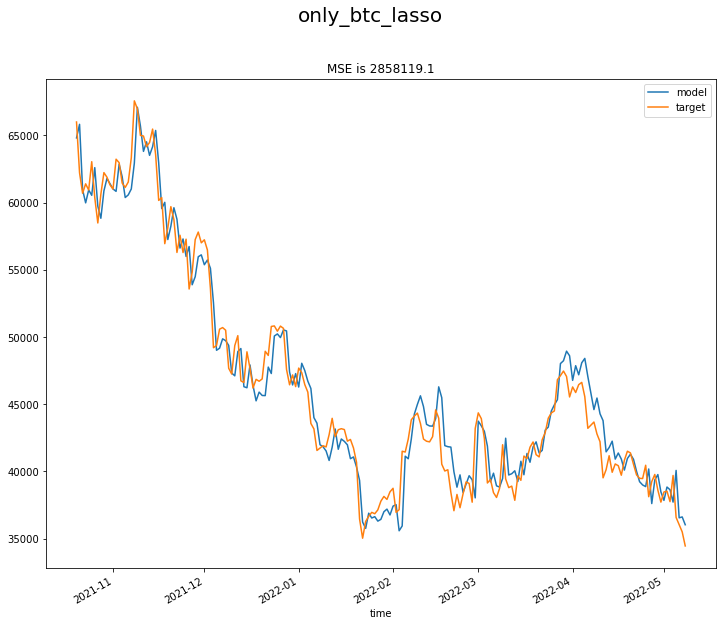

In [7]:
eval_model.visualize_plot(lasso_only_predict[-200:], y[-200:], name="only_btc_lasso")

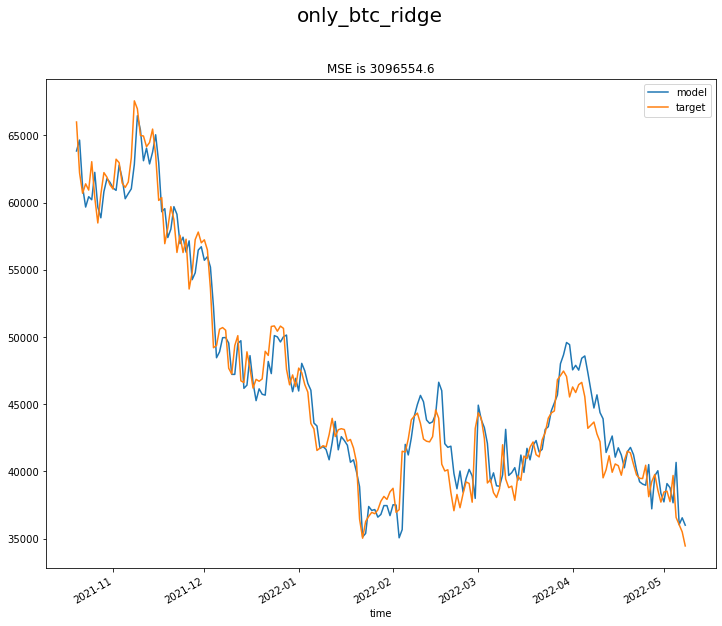

In [8]:
eval_model.visualize_plot(ridge_only_predict[-200:], y[-200:], name="only_btc_ridge")


비트코인 데이터로만 학습한 모델을 최적화 하자

In [9]:
def plot_bar(data, name):
    cnts = data.value_counts()
    cnts.sort_values(ascending=False,inplace=True)
    plt.figure(figsize=(12,8))
    plt.bar(cnts.index, cnts.values)
    plt.ylabel("Count")
    plt.xlabel(f"{name} %")
    plt.xticks(range(-100,100,10))
    plt.title(name)
    plt.xlim(-100,100)

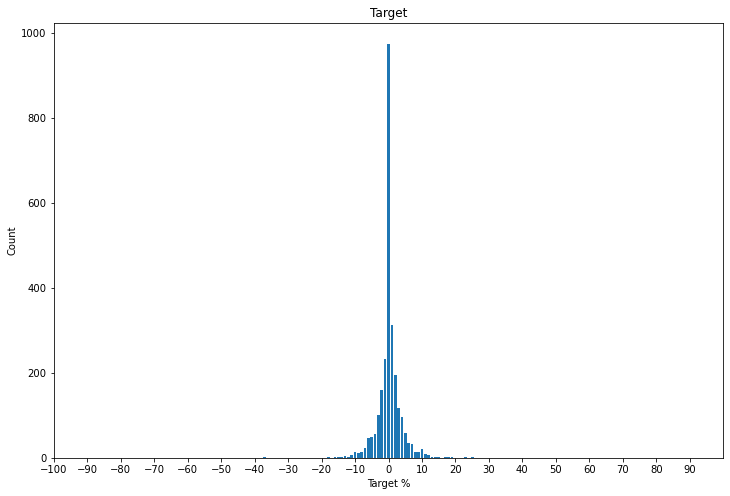

In [10]:
plot_bar(df['Pct'].astype(int), name="Target")

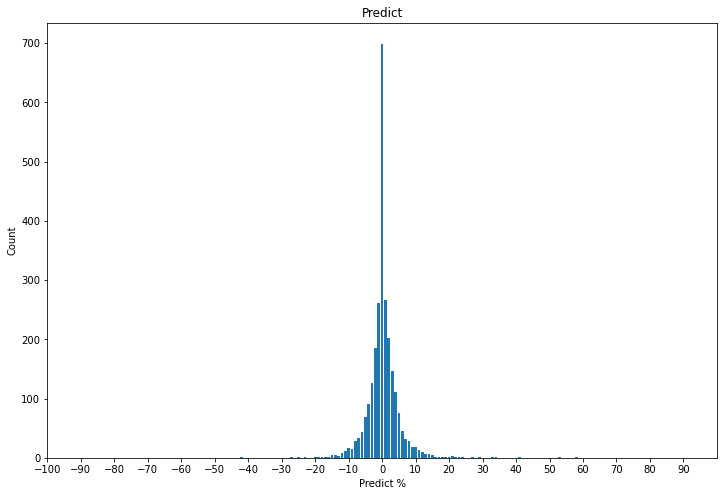

In [11]:
pred_pct = lasso_only_predict.pct_change().dropna() * 100
plot_bar(pred_pct.astype(int), name="Predict")

var: 48.97045825222123, mean: 1.0962850822795873


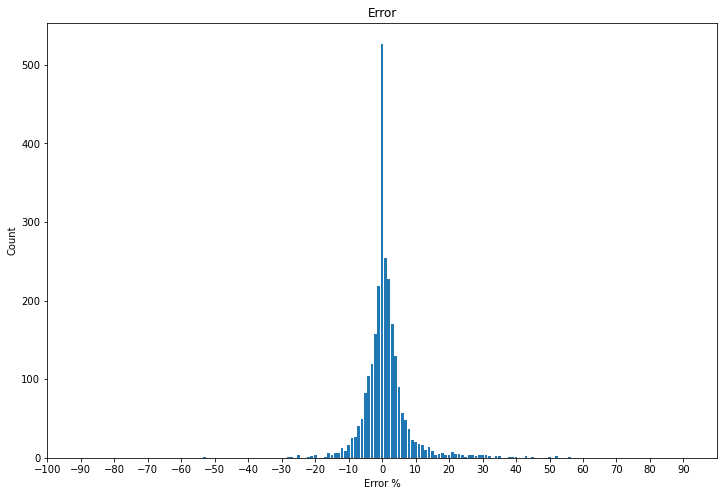

In [12]:
error = (y - lasso_only_predict) * 100 / y
error_mean = error.mean()
error_var = error.var()
error = error.astype(int)
print(f"var: {error_var}, mean: {error_mean}")
plot_bar(error,name="Error")


In [13]:
def get_thershold(pred_pct, X):
    for t in range(-5,5):
        pred_pct = pred_pct.round(2)
        price_pct = df['Pct'].iloc[1:] #y와 인덱스를 맞춰준다.
        true_pos = pred_pct[(pred_pct > t) & (price_pct > 0)] #모델이 상승세라 예측했고 실제로 상승한 날들
        false_pos = pred_pct[(pred_pct > t) & (price_pct <= 0)]
        true_neg = pred_pct[(pred_pct < t) & (price_pct < 0)]
        false_neg = pred_pct[(pred_pct < t) & (price_pct >= 0)]
        print("Threshold: ", t)
        print(f"true_pos: {len(true_pos)}, false_pos: {len(false_pos)}")
        print(f"true_neg: {len(true_neg)}, false_neg: {len(false_neg)}")
        precison = len(true_pos) / (len(true_pos) + len(false_pos))
        recall = len(true_pos) / (len(true_pos) + len(false_neg))
        f1 = (2 * precison * recall) / (precison + recall)
        print("Precision: ",precison)
        print("Recall: ",recall)
        print("F1: ", f1)

now_price = df['Price'].iloc[:-1]
pred_profit = 100 * (lasso_only_predict.values - now_price.values) / now_price
get_thershold(pred_profit, X)
# get_thershold(pred_pct, X)
    

Threshold:  -5
true_pos: 1282, false_pos: 1078
true_neg: 118, false_neg: 144
Precision:  0.5432203389830509
Recall:  0.8990182328190743
F1:  0.6772319070258848
Threshold:  -4
true_pos: 1241, false_pos: 1041
true_neg: 156, false_neg: 185
Precision:  0.5438212094653813
Recall:  0.8702664796633941
F1:  0.6693635382955772
Threshold:  -3
true_pos: 1185, false_pos: 969
true_neg: 228, false_neg: 241
Precision:  0.5501392757660167
Recall:  0.8309957924263675
F1:  0.6620111731843575
Threshold:  -2
true_pos: 1066, false_pos: 852
true_neg: 343, false_neg: 361
Precision:  0.5557872784150156
Recall:  0.747021723896286
F1:  0.6373692077727952
Threshold:  -1
true_pos: 915, false_pos: 705
true_neg: 489, false_neg: 513
Precision:  0.5648148148148148
Recall:  0.6407563025210085
F1:  0.6003937007874016
Threshold:  0
true_pos: 703, false_pos: 515
true_neg: 679, false_neg: 724
Precision:  0.577175697865353
Recall:  0.4926419060967064
F1:  0.5315689981096408
Threshold:  1
true_pos: 509, false_pos: 335
true_

In [14]:
pred_profit

time
2015-02-28    -4.972239
2015-03-01    -1.929228
2015-03-02     0.564319
2015-03-03   -11.786686
2015-03-04   -13.491039
                ...    
2022-05-03    -0.092013
2022-05-04     0.946194
2022-05-05    -0.073320
2022-05-06     1.587319
2022-05-07     1.492217
Name: Price, Length: 2625, dtype: float64

In [15]:
def get_profit_pct(pred_pct, thereshold): 
    """ 예측 데이터와 실제 가격의 증감률의 차이에 따라 투자 조건을 다르게 했을 때의
        달라지는 수익률 곡선을 구해준다.
    """
    buy_point = [] #예측 값이 %이상일 때 매수한다.
    sell_point = [] #손익을 실현 시키기 이전 거래일
    for i in pred_pct[pred_pct.values > thereshold].index:
        try:
            index = y.index.get_loc(i) + 1        #매수 다음 거래일에 바로 매도한다.
            if index < len(y):
                sell_point.append(index)
                buy_point.append(index - 1)
        except: 
            continue
            
    buy_value = y.iloc[buy_point]
    sell_value = y.iloc[sell_point]
    profit_pct = (sell_value.values - buy_value.values) / buy_value.values
    return pd.Series(index=sell_value.index, data=profit_pct)

def get_profit(profit_pct, days=0):
    seed = 1 #처음 seed
    seed_record = []
    for p in profit_pct[-days:]:
        seed = seed * (1 + p)  #profit 저장용
        seed_record.append(seed)
    return seed_record

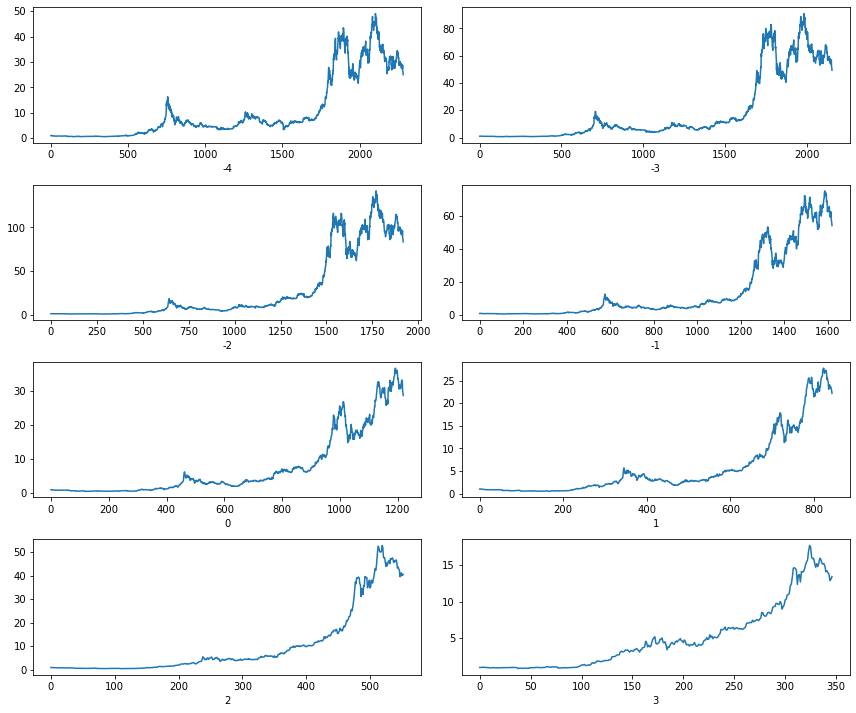

In [16]:
n_split = 8
start = -4
end = start + n_split
rows = lambda x: x//2 if x % 2 == 0 else x//2 + 1
fig, axes = plt.subplots(rows(n_split), 2, figsize=(12,10))
results = {}
for i, v in enumerate(range(start, end), start=1):
    profit_pct = get_profit_pct(pred_profit, v)
    results[v] = pd.Series(index=profit_pct.index ,data=profit_pct)
    plt.subplot(rows(n_split), 2, i)
    plt.plot(get_profit(results[v]))
    plt.xlabel(v)
plt.tight_layout()

(18820.0, 19120.0)

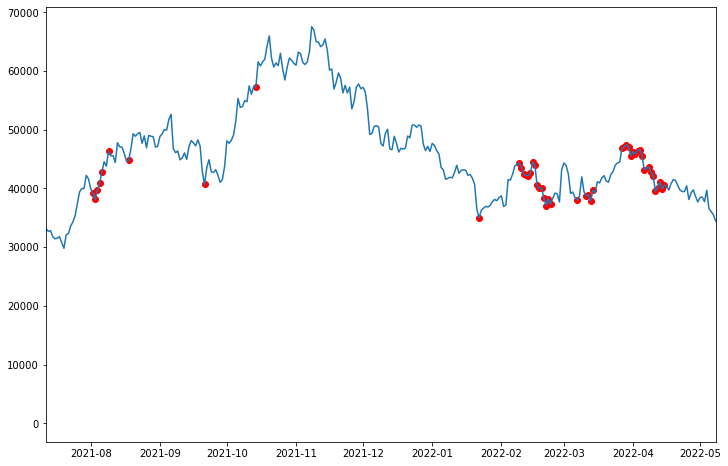

In [19]:
buy_point = pred_profit[pred_profit > 2] #가장 precision이 높은 수치
buy_value = y[buy_point.index]
plt.figure(figsize=(12,8))
plt.plot(y)
plt.scatter(x=buy_point.index, y = buy_value, c='r')
plt.xlim(df.index[-300],df.index[-1])


In [17]:
for r in results:
    print(f"{r}: {len(results[r])}")

-4: 2283
-3: 2155
-2: 1919
-1: 1620
0: 1220
1: 844
2: 553
3: 347


In [66]:
momentum = {}
FIRST = 5
SECOND = 10
THIRD = 30
for k in results.keys():
    profit = results[k] * 100
    short = profit.rolling(FIRST).apply(lambda x: x.prod() ** (1.0 / FIRST))
    # mid = profit / profit.rolling(SECOND).mean() #1달 간의 기하 평균 수익률
    # long = profit / profit.rolling(THIRD).mean() #2달 간의 기하 평균 수익률
    # # apply(lambda x: x.prod() ** (1.0 / SECOND))
    # momentum[k] = (short * 0.5 + mid * 0.3 + long * 0.2)
    momentum[k] = short

In [67]:
moment_df = pd.DataFrame(momentum)
moment_df = moment_df.ffill()
moment_df = moment_df.fillna(0)
moment_df

,-4,-3,-2,-1,0,1,2,3
time,,,,,,,,
2015-03-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-03-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-03-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-03-10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-03-15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
2022-05-04,1.499091,1.499091,1.499091,1.499091,1.144917,1.423248,1.423248,2.498491
2022-05-05,1.914142,1.914142,1.914142,1.914142,1.465527,1.423248,1.423248,2.498491
2022-05-06,1.914142,1.914142,1.914142,1.914142,1.465527,1.423248,1.423248,2.498491


In [68]:
moment_df.max()

-4     8.366104
-3     8.366104
-2     8.366104
-1     7.767270
 0     9.458993
 1    10.908760
 2     8.194474
 3     7.465864
dtype: float64

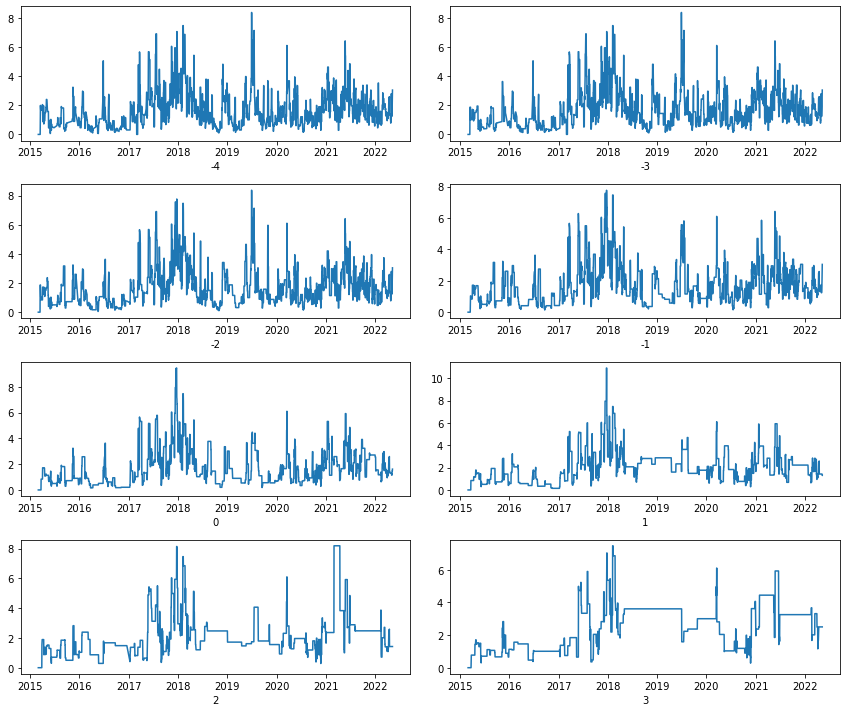

In [69]:
fig, axes = plt.subplots(rows(n_split), 2, figsize=(12,10))
for i, v in enumerate(range(start, end), start=1):
    plt.subplot(rows(n_split), 2, i)
    plt.plot(moment_df[v])
    plt.xlabel(v)
plt.tight_layout()

In [71]:
thers_df = moment_df.idxmax(axis=1)
thers_df

time
2015-03-02   -4
2015-03-03   -4
2015-03-08   -4
2015-03-10   -4
2015-03-15   -4
             ..
2022-05-04    3
2022-05-05    3
2022-05-06    3
2022-05-07   -4
2022-05-08   -4
Length: 2283, dtype: int64

In [74]:
profit_df = pd.DataFrame([thers_df,pred_profit]).T
profit_df.columns =["threshold","profit_pct"]
profit_df.dropna(inplace=True)
profit_df

,threshold,profit_pct
time,,
2015-03-02,-4.0,0.564319
2015-03-03,-4.0,-11.786686
2015-03-08,-4.0,-6.386556
2015-03-10,-4.0,-13.275859
2015-03-15,-4.0,1.928742
...,...,...
2022-05-03,3.0,-0.092013
2022-05-04,3.0,0.946194
2022-05-05,3.0,-0.073320


In [80]:
profit_df[profit_df['threshold'] < profit_df['profit_pct']]

,threshold,profit_pct
time,,
2015-03-02,-4.0,0.564319
2015-03-15,-4.0,1.928742
2015-03-16,-3.0,-2.055393
2015-03-20,-3.0,8.118335
2015-03-21,-4.0,5.650945
...,...,...
2022-04-14,-4.0,2.454011
2022-04-15,-4.0,2.007789
2022-04-29,-4.0,-0.348684


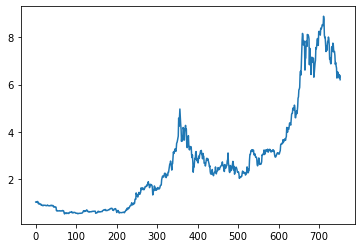

In [82]:
buy_point = [] #예측 값이 %이상일 때 매수한다.
sell_point = [] #손익을 실현 시키기 이전 거래일
for i in profit_df[profit_df['threshold'] < profit_df['profit_pct']].index:
    try:
        index = y.index.get_loc(i) + 1        #매수 다음 거래일에 바로 매도한다.
        if index < len(y):
            sell_point.append(index)
            buy_point.append(index - 1)
    except: 
        continue
            
buy_value = y.iloc[buy_point]
sell_value = y.iloc[sell_point]
profit_pct = (sell_value.values - buy_value.values) / buy_value.values
plt.plot(get_profit(pd.Series(index=sell_value.index, data=profit_pct)))
